## Logo
This is based on the functions from the MPL documentation page here: https://matplotlib.org/stable/gallery/misc/logos2.html

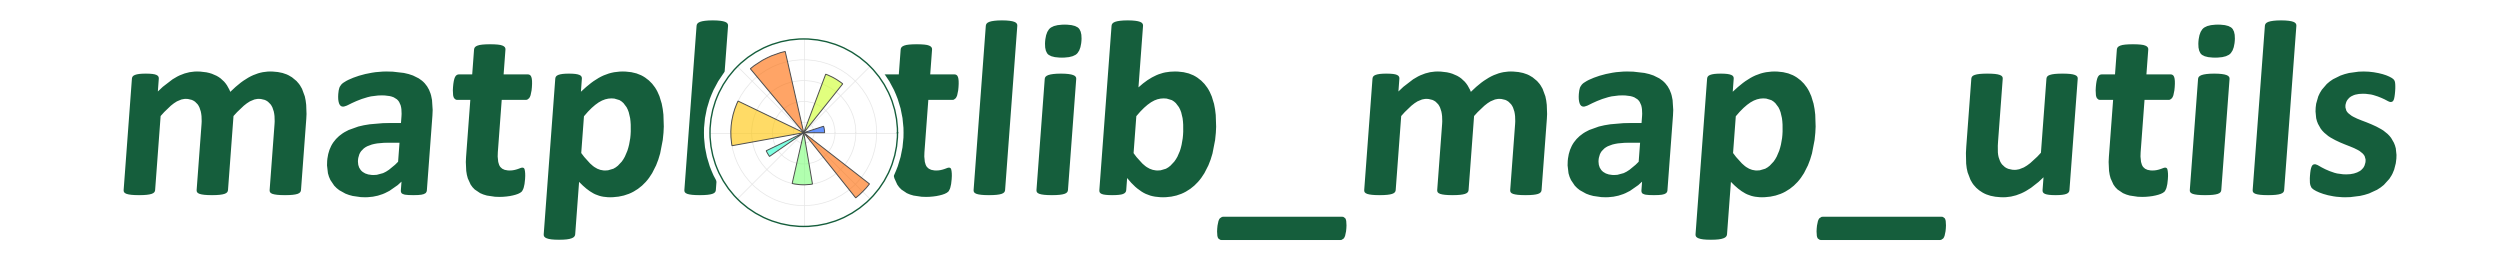

In [23]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.cm as cm
import matplotlib.font_manager
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.text import TextPath
import matplotlib.transforms as mtrans

# NOTE: updated to a soft green
MMU_GREEN = '#155e3c'


def get_font_properties():
    # NOTE: had to update
    if matplotlib.font_manager.findfont('Calibri:bold'):
        return matplotlib.font_manager.FontProperties(family='Calibri',
                                                      weight='bold')
    if matplotlib.font_manager.findfont('Carlito:bold'):
        print('Original font not found. Falling back to Carlito. '
              'The logo text will not be in the correct font.')
        return matplotlib.font_manager.FontProperties(family='Carlito',
                                                      weight='bold')
    print('Original font not found. '
          'The logo text will not be in the correct font.')
    return None


def create_icon_axes(fig, ax_position, lw_bars, lw_grid, lw_border, rgrid):
    """
    Create a polar Axes containing the matplotlib radar plot.

    Parameters
    ----------
    fig : matplotlib.figure.Figure
        The figure to draw into.
    ax_position : (float, float, float, float)
        The position of the created Axes in figure coordinates as
        (x, y, width, height).
    lw_bars : float
        The linewidth of the bars.
    lw_grid : float
        The linewidth of the grid.
    lw_border : float
        The linewidth of the Axes border.
    rgrid : array-like
        Positions of the radial grid.

    Returns
    -------
    ax : matplotlib.axes.Axes
        The created Axes.
    """
    with plt.rc_context({'axes.edgecolor': MMU_GREEN,
                         'axes.linewidth': lw_border}):
        ax = fig.add_axes(ax_position, projection='polar')
        ax.set_axisbelow(True)

        N = 7
        arc = 2. * np.pi
        theta = np.arange(0.0, arc, arc / N)
        radii = np.array([2, 6, 8, 7, 4, 5, 8])
        width = np.pi / 4 * np.array([0.4, 0.4, 0.6, 0.8, 0.2, 0.5, 0.3])
        bars = ax.bar(theta, radii, width=width, bottom=0.0, align='edge',
                      edgecolor='0.3', lw=lw_bars)
        for r, bar in zip(radii, bars):
            color = *cm.jet(r / 10.)[:3], 0.6  # color from jet with alpha=0.6
            bar.set_facecolor(color)

        ax.tick_params(labelbottom=False, labeltop=False,
                       labelleft=False, labelright=False)

        ax.grid(lw=lw_grid, color='0.9')
        ax.set_rmax(9)
        ax.set_yticks(rgrid)

        # the actual visible background - extends a bit beyond the axis
        ax.add_patch(Rectangle((0, 0), arc, 9.58,
                               facecolor='white', zorder=0,
                               clip_on=False, in_layout=False))
        return ax


def create_text_axes(fig, height_px):
    """Create an Axes in *fig* that contains 'matplotlib' as Text."""
    ax = fig.add_axes((0, 0, 1, 1))
    ax.set_aspect("equal")
    ax.set_axis_off()

    path = TextPath((0, 0), "matplotlib_map_utils", size=height_px * 0.8,
                    prop=get_font_properties())

    angle = 4.25  # degrees
    trans = mtrans.Affine2D().skew_deg(angle, 0)

    patch = PathPatch(path, transform=trans + ax.transData, color=MMU_GREEN,
                      lw=0)
    ax.add_patch(patch)
    ax.autoscale()


def make_logo(height_px, lw_bars, lw_grid, lw_border, rgrid, with_text=False):
    """
    Create a full figure with the Matplotlib logo.

    Parameters
    ----------
    height_px : int
        Height of the figure in pixel.
    lw_bars : float
        The linewidth of the bar border.
    lw_grid : float
        The linewidth of the grid.
    lw_border : float
        The linewidth of icon border.
    rgrid : sequence of float
        The radial grid positions.
    with_text : bool
        Whether to draw only the icon or to include 'matplotlib' as text.
    """
    dpi = 100
    height = height_px / dpi
    figsize = (5 * height, height) if with_text else (height, height)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    # NOTE: updated this
    fig.patch.set_alpha(1)

    if with_text:
        create_text_axes(fig, height_px)
    # NOTE updated this, manually positioned it
    ax_pos = (0.28, 0.12, .075, 0.75) if with_text else (0.03, 0.03, .94, .94)
    ax = create_icon_axes(fig, ax_pos, lw_bars, lw_grid, lw_border, rgrid)

    return fig, ax

make_logo(height_px=500, lw_bars=0.7, lw_grid=0.5, lw_border=1,
          rgrid=[1, 3, 5, 7], with_text=True)
# plt.show()
plt.savefig("./mmu_logo.png", bbox_inches="tight")

## Big Example Maps

In [1]:
import pygris
import geopandas
import pyproj
import shapely
import contextily
import matplotlib.pyplot
from matplotlib_map_utils.core import north_arrow, scale_bar, ScaleBar, inset_map, indicate_detail, indicate_extent
from matplotlib_map_utils.utils import USA

In [2]:
# This is just a function to create a new, blank map with matplotlib, with our default settings
def new_map(rows=1, cols=1, figsize=(5,5), dpi=150, ticks=False):
    # Creating the plot(s)
    fig, ax = matplotlib.pyplot.subplots(rows,cols, figsize=figsize, dpi=dpi)
    # Turning off the x and y axis ticks
    if ticks==False:
        if rows > 1 or cols > 1:
            for a in ax.flatten():
                a.set_xticks([])
                a.set_yticks([])
        else:
            ax.set_xticks([])
            ax.set_yticks([])
    # Returning the fig and ax
    return fig, ax

In [3]:
# states = pygris.states(cb=True, year=2022, cache=False).to_crs(3857)
states = geopandas.read_file("../../scratch/states.gpkg").to_crs(3857)
usa = USA()
contiguous = states.query(f"GEOID in {usa.filter_contiguous(True)}")
georgia = states.query(f"GEOID == '{usa.filter_abbr("GA")}'")

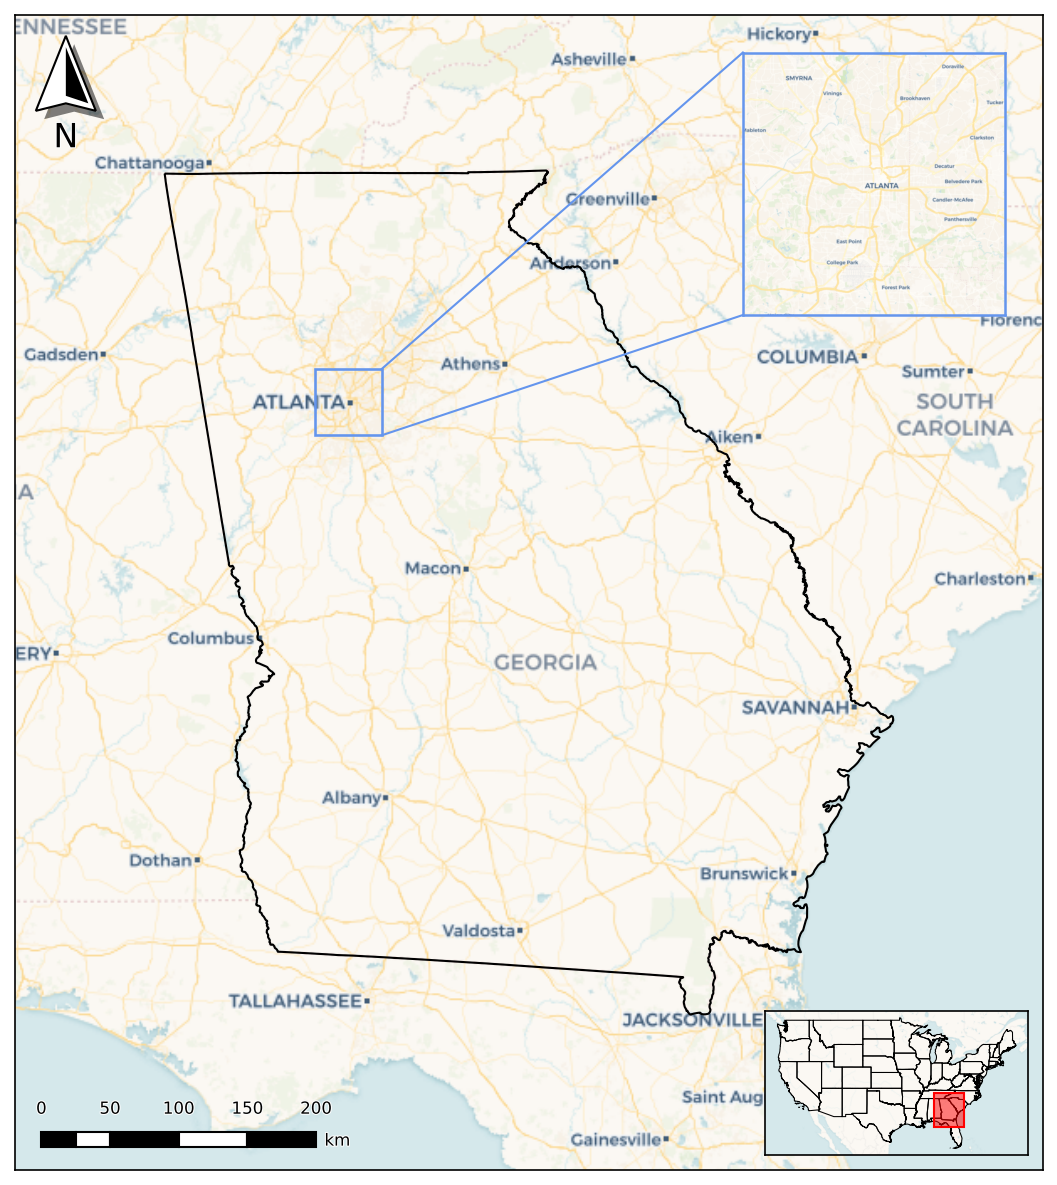

In [30]:
# Making a map of Georgia
fig, ax = new_map(figsize=(10,10))
georgia.buffer(75000).plot(ax=ax, facecolor="none", edgecolor="none") # this helps us "zoom out" a bit
georgia.plot(ax=ax, edgecolor="black", facecolor="none")

# Creating an inset map and extent indicator for the USA
cax = inset_map(ax, "lower right", size=1.75, pad=0.1, xticks=[], yticks=[])
contiguous.plot(ax=cax, facecolor="none", edgecolor="black", linewidth=0.5)
indicate_extent(cax, ax, 3857, 3857)

# Creating an inset map and detail indicator for Atlanta, GA
atl_centroid = shapely.Point(pyproj.Transformer.from_crs(4326, 3857, always_xy=True).transform(-84.40123859860549, 33.75203795433787))
atl_buffer = atl_centroid.buffer(20000)
aax = inset_map(ax, "upper right", size=1.75, pad=0.25, xticks=[], yticks=[])
geopandas.GeoSeries(atl_buffer).plot(ax=aax, facecolor="none", edgecolor="none")
indicate_detail(ax, aax, 3857, 3857, linecolor="cornflowerblue")
# aax.set_title("Atlanta, GA", fontdict={"fontsize":10})

# Creating a north arrow
na = north_arrow(ax=ax, location="upper left", scale=0.5, rotation={"degrees":0})

# Creating a scale bar
sb = scale_bar(ax=ax, style="boxes", location="lower left", bar={"length":2, "projection":3857}, text={"fontsize":8})

# Adding contextily basemaps
contextily.add_basemap(ax, attribution="", source=contextily.providers.CartoDB.Voyager)
contextily.add_basemap(cax, attribution="", source=contextily.providers.CartoDB.VoyagerNoLabels)
contextily.add_basemap(aax, attribution="", source=contextily.providers.CartoDB.Voyager)

matplotlib.pyplot.savefig("./readme_bigmap.png", bbox_inches="tight")

## Examples

### North Arrow

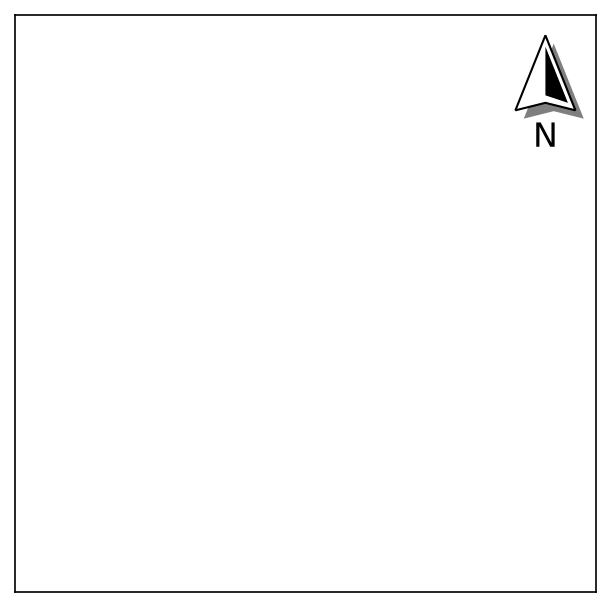

In [17]:
# README north arrow plot

# Setting up a plot
fig, ax = new_map()
# Adding a north arrow to the upper-right corner of the axis, without any rotation (see Rotation under Formatting Components for details)
north_arrow(ax=ax, location="upper right", rotation={"degrees":0})

matplotlib.pyplot.savefig("./readme_northarrow.png", bbox_inches="tight")

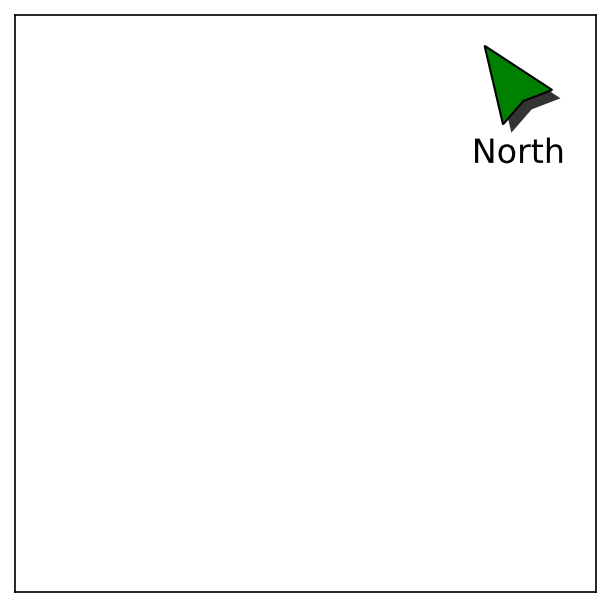

In [5]:
# README north arrow plot

# Setting up a plot
fig, ax = new_map()
# Adding a more customized north arrow
north_arrow(
    ax,
    location = "upper right", # accepts a valid string from the list of locations
    scale = 0.5, # accepts a valid positive float or integer
    # each of the follow accepts arguments from a customized style dictionary
    base = {"facecolor":"green"},
    fancy = False,
    label = {"text":"North"},
    shadow = {"alpha":0.8},
    pack = {"sep":6},
    aob = {"pad":1},
    rotation = {"degrees": 35})

matplotlib.pyplot.savefig("./readme_northarrow_customization.png", bbox_inches="tight")

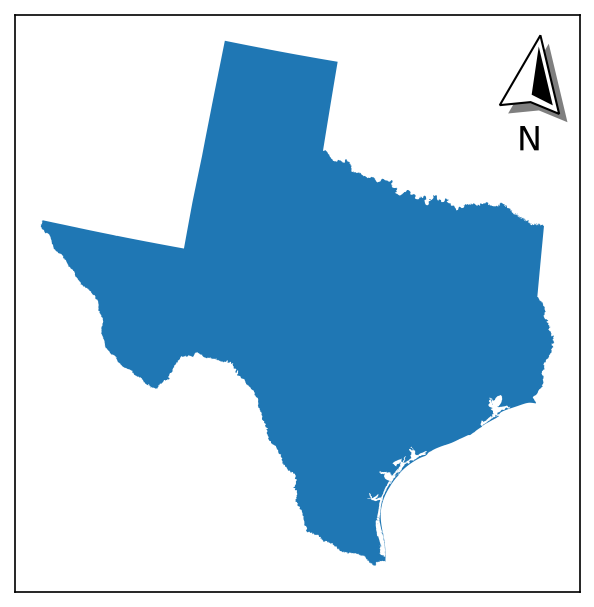

In [18]:
# README north arrow rotation
states = pygris.states(cb=True, year=2022, cache=False).to_crs(3857)
# Setting up a plot
fig, ax = new_map()
# Plotting a state (Texas)
states.query("NAME=='Texas'").to_crs(3520).plot(ax=ax)
# Adding a north arrow to the upper-right corner of the axis, without any rotation (see Rotation under Formatting Components for details)
north_arrow(ax=ax, location="upper right", rotation={"crs":3520, "reference":"center"})

matplotlib.pyplot.savefig("./readme_northarrow_rotation.png", bbox_inches="tight")

### Scale Bar

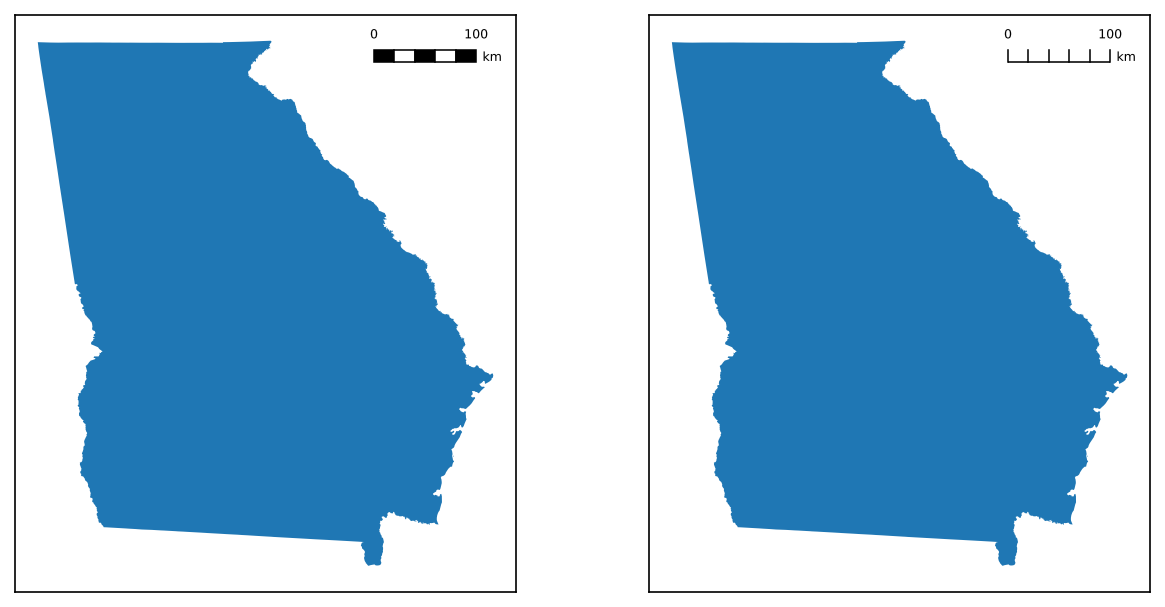

In [17]:
# README scalebars
# Setting up a plot
fig, ax = new_map(1,2, figsize=(10,5))
# Changing the size
ScaleBar.set_size("sm")
# Plotting a state (Georgia)
states.query("NAME=='Georgia'").to_crs(3520).plot(ax=ax[0])
states.query("NAME=='Georgia'").to_crs(3520).plot(ax=ax[1])
# Adding a scale bar to the upper-right corner of the axis, in the same projection as whatever geodata you plotted
scale_bar(ax=ax[0], location="upper right", style="boxes", bar={"projection":3520})
scale_bar(ax=ax[1], location="upper right", style="ticks", bar={"projection":3520})

matplotlib.pyplot.savefig("./readme_scalebar.png", bbox_inches="tight")

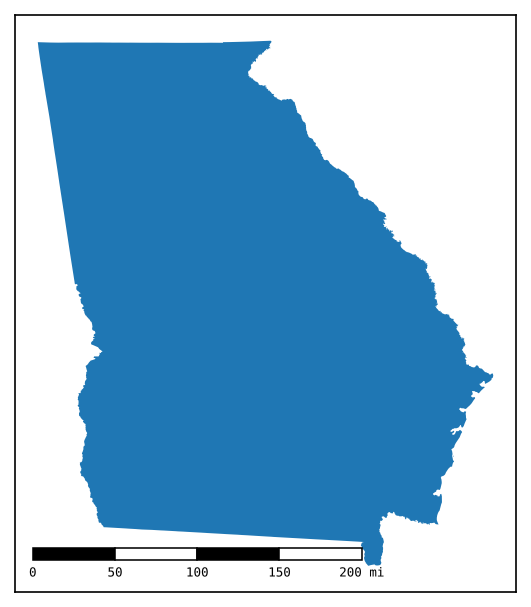

In [16]:
# README scalebars with customization
# Setting up a plot
fig, ax = new_map(1,1, figsize=(5,5))
# Plotting a state (Georgia)
states.query("NAME=='Georgia'").to_crs(3520).plot(ax=ax)
# Adding a scale bar to the upper-right corner of the axis, in the same projection as whatever geodata you plotted
scale_bar(ax=ax, location="lower left", style="boxes",
          # each of the follow accepts arguments from a customized style dictionary
            bar = {"projection":3520, "unit":"mi", "length":1.75}, # converting the units to miles, and changing the length of the bar (in inches)
            labels = {"style":"major", "loc":"below"}, # placing a label on each major division, and moving them below the bar
            units = {"loc":"text"}, # changing the location of the units text to the major division labels
            text = {"fontfamily":"monospace"}, # changing the font family of all the text to monospace)
        )

matplotlib.pyplot.savefig("./readme_scalebar_customization.png", bbox_inches="tight")

### Inset Map

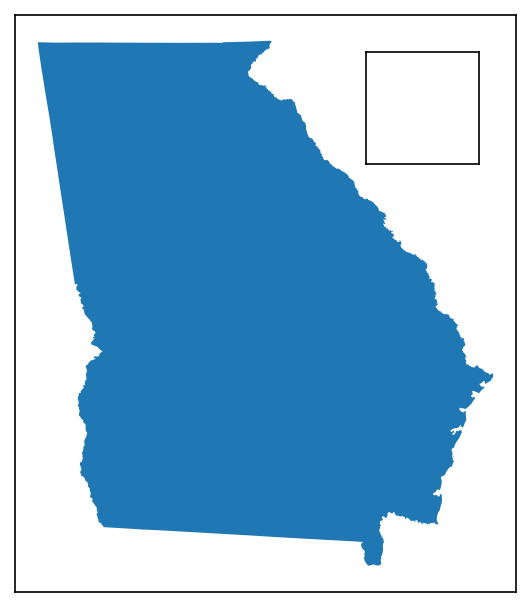

In [34]:
# Setting up a plot
fig, ax = new_map(1,1, figsize=(5,5))
# Plotting a state (Georgia)
states.query("NAME=='Georgia'").to_crs(3520).plot(ax=ax)
# Adding an inset map to the upper-right corner of the axis
iax = inset_map(ax=ax, location="upper right", size=0.75, pad=0.25, xticks=[], yticks=[])
# You can now plot additional data to iax as desired
matplotlib.pyplot.savefig("./readme_insetmap.png", bbox_inches="tight")

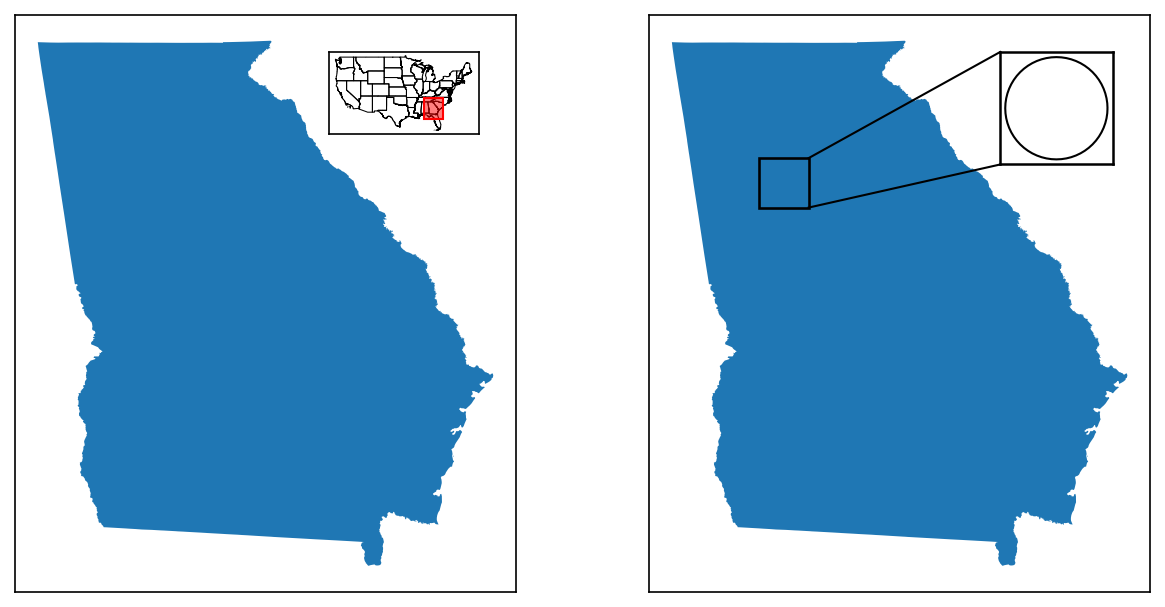

In [40]:
# Setting up a plot
fig, ax = new_map(1,2, figsize=(10,5))
# Plotting a state (Georgia)
states.query("NAME=='Georgia'").to_crs(3520).plot(ax=ax[0])
states.query("NAME=='Georgia'").to_crs(3520).plot(ax=ax[1])
# Adding an inset map to the upper-right corner of the axis
iax0 = inset_map(ax=ax[0], location="upper right", size=1, pad=0.25, xticks=[], yticks=[])
iax1 = inset_map(ax=ax[1], location="upper right", size=0.75, pad=0.25, xticks=[], yticks=[])
# Adding an extent indicator for the map on the left
contiguous.plot(ax=iax0, facecolor="none", edgecolor="black", linewidth=0.5)
indicate_extent(iax0, ax[0], 3857, 3520, pad=0.25)

# Adding a detail indicator for the plot on the left
atl_centroid = shapely.Point(pyproj.Transformer.from_crs(4326, 3520, always_xy=True).transform(-84.40123859860549, 33.75203795433787))
atl_buffer = atl_centroid.buffer(20000)
geopandas.GeoSeries(atl_buffer).plot(ax=iax1, facecolor="none", edgecolor="black")
indicate_detail(ax[1], iax1, 3520, 3520)

# You can now plot additional data to iax as desired
matplotlib.pyplot.savefig("./readme_indicators.png", bbox_inches="tight")